In [138]:
import os 
import pandas as pd
import yfinance as yf
import numpy as np
from dagster import Config
from datetime import date
from sklearn.ensemble import IsolationForest
import pickle
from scipy.stats import norm, spearmanr

In [3]:
class TSConfig():
    tickers_load_url: str = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    outdir: str = '/app/data'
    raw_tickers_path: str = ''
    start_date: str = "2017-01-01"  

In [4]:
config = TSConfig()

today = str(date.today())   
today_directory = f'{config.outdir}/{today}'
if not os.path.exists(today_directory):
    os.mkdir(today_directory)
    config.outdir = today_directory
    os.mkdir(f'{today_directory}/raw_data_tickers')
    config.raw_tickers_path = f'{today_directory}/raw_data_tickers'


In [5]:
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
tables = pd.read_html(url)
sp500_table = tables[0]
tickers = sp500_table['Symbol'].tolist()
with open(f'{config.outdir}/tickers_list.pkl', 'wb') as fp:
    pickle.dump(tickers, fp)


In [6]:
tickers_list = []
with open (f'{config.outdir}/tickers_list.pkl', 'rb') as fp:
    tickers_list = pickle.load(fp)
#TODO: could be parallelized  
for ticker in tickers_list:
    data = yf.download(ticker, start=config.start_date)
    data['ticker'] = ticker
    data.reset_index().to_parquet(f'{config.raw_tickers_path}/{ticker}.parquet')


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [7]:
tickers_list = []

with open (f'{config.outdir}/tickers_list.pkl', 'rb') as fp:
    tickers_list = pickle.load(fp)
dfs = []
for ticker in tickers_list:
    df = pd.read_parquet(f'{config.raw_tickers_path}/{ticker}.parquet')
    dfs.append(df)

combined_data = pd.concat(dfs,axis=0).reset_index().rename(str.lower, axis='columns').set_index(['date','ticker']).sort_index().drop(columns=['index'])
combined_data.reset_index().to_parquet(f'{config.outdir}/combined_data.parquet')

/tmp/ipykernel_2098/2563984436.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_data = pd.concat(dfs,axis=0).reset_index().rename(str.lower, axis='columns').set_index(['date','ticker']).sort_index().drop(columns=['index'])


In [8]:
data = pd.read_parquet(f'{config.outdir}/combined_data.parquet').set_index(['date','ticker'])
isolation_forest = IsolationForest(contamination=0.01, random_state=42)
predictions = isolation_forest.fit_predict(data)
cleaned_data = data[predictions == 1].copy()

In [9]:
cleaned_data['target_1d'] = cleaned_data['adj close'].groupby('ticker').pct_change()
cleaned_data.dropna().reset_index().to_parquet(f'{config.outdir}/combined_cleaned_data.parquet')

In [47]:
# https://www.msci.com/documents/1296102/8473352/Volatility-brochure.pdf/f9cac8cb-f467-470d-9292-0298a597799e
data = pd.read_parquet(f'{config.outdir}/combined_cleaned_data.parquet').set_index(['date','ticker'])
data['return_1d'] = data['target_1d'].groupby('ticker').shift(1)
data['volatilty_1y'] = data['return_1d'].groupby('ticker').ewm(halflife=126).std().droplevel(0)
data['vol_perc'] = data['volatilty_1y'].groupby('date').rank(pct=True).dropna()
data['alpha'] = data.groupby('date')['vol_perc'].transform(lambda x: norm.ppf(x.clip(lower=0.000001, upper=0.999999)))
data.dropna().reset_index().to_parquet(f'{config.outdir}/res_data.parquet')

In [116]:
data = pd.read_parquet(f'{config.outdir}/res_data.parquet').set_index(['date','ticker'])
data['alpha_norm'] = data.groupby('date')['alpha'].transform(lambda x: x - x.mean())
data['alpha_norm'] = data['alpha_norm'].groupby('date').transform(lambda x: x * (2 / x.abs().sum()))

In [120]:
pnl_res = (data['alpha_norm'] * data['target_1d']).groupby('date').sum()


<Axes: xlabel='date'>

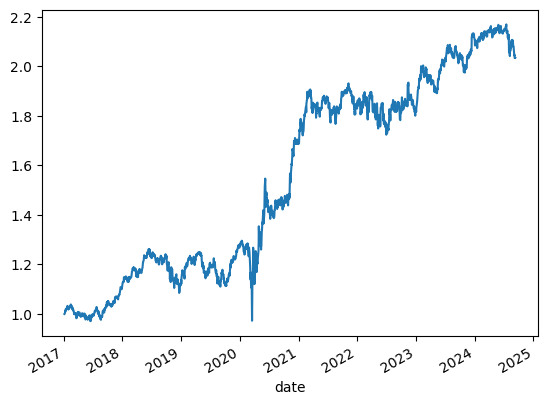

In [126]:
(1+pnl_res.cumsum()).plot()

In [132]:
res_df = pd.DataFrame(((data['alpha_norm'] * data['target_1d']).groupby('date').sum()),columns=['returns'])

In [136]:
res_df['pnl'] = (1 + res_df['returns'].cumsum())

<Axes: xlabel='date'>

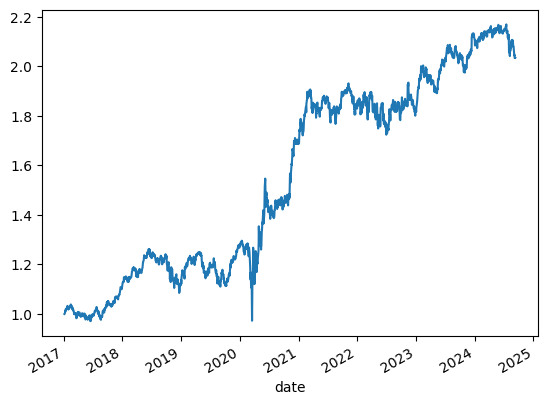

In [137]:
res_df['pnl'].plot()

In [143]:
def annualized_sharpe_ratio(returns, risk_free_rate=0, trading_days=252):
    excess_returns = returns - risk_free_rate
    sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns, ddof=1)
    return sharpe_ratio * np.sqrt(trading_days)

def max_drawdown(returns):
    cumulative = (1 + returns).cumprod()
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak
    return drawdown.min()

def information_coefficient(predicted_returns, actual_returns):
    return spearmanr(predicted_returns, actual_returns)[0]

def hit_rate(predicted_returns, actual_returns):
    return np.mean(np.sign(predicted_returns) == np.sign(actual_returns))

def annualized_volatility(returns, trading_days=252):
    return np.std(returns) * np.sqrt(trading_days)

def annualized_return(returns, trading_days=252):
    cumulative_return = (1 + returns).prod()
    return cumulative_return**(trading_days / len(returns)) - 1

def calmar_ratio(returns, trading_days=252):
    ann_return = annualized_return(returns, trading_days)
    max_dd = max_drawdown(returns)
    return ann_return / abs(max_dd) if max_dd != 0 else np.nan


In [157]:
pd.DataFrame.from_dict(scores, orient='index',columns=['score'])

,score
sharpe,0.662115
max_dd,-0.284293
volatility,0.203895
ann_returns,0.121093
calmar_ratio,0.425946
information_coefficient,0.002919
hit_rate,0.490696


np.float64(0.20389535935035172)

np.float64(0.12109345906778346)

np.float64(0.425946106950207)

np.float64(0.002918895579493121)

In [147]:
hit_rate(data['alpha_norm'],data['target_1d'])

np.float64(0.49069592857028765)